# **Klasifikasi Penyakit wajah (CNN)**

#Step 1: Melakukan Import packages
Berikut daftar library packages yang kami gunakan untuk mengklasifikasi jenis penyakit pada wajah. kami menggunakan tools-tools dari Tensorflow dan Keras. Setelah itu kami menjalankan method dari tensorflow untuk memastikan machine learning yang akan kami gunakan akan dilatih menggunakan GPU.

In [1]:
#!pip install tensorflowjs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import regularizers, preprocessing
from keras.layers import Input, Flatten, Dropout, Dense, Conv2D, MaxPooling2D, BatchNormalization, concatenate, GlobalAveragePooling2D
from keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l1, l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tqdm import tqdm

import os
import pathlib

physical_devices= tf.config.list_physical_devices("GPU")

#Melakukan pengecekkan apakah menggunakan GPU atau tidak.
if len(physical_devices) > 0:
    print("Akan menggunakan GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Tidak ada GPU terdeteksi")

Tidak ada GPU terdeteksi


In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Step 2: Pendeklarasian variabel untuk melakukan setting opsi.


In [3]:
PATH=r"/content/drive/MyDrive/dermafie/image" #Gantikan path ini ke lokasi data kaggle yang sudah didownload dan diupload ke gdrive anda
RESIZE=224
BATCH_SIZE=16
NUM_EPOCHS=32
TEST_SIZE=0.2

#Step 3: Membangun Dataframe menggunakan pandas dari folder images.
Setelah itu kami akan membuat dataset dalam bentuk dataframe menggunakan library pandas.

In [4]:
def make_dataframes(sdir):
    filepaths=[]
    labels=[]
    files_include_txt=sorted(os.listdir(sdir))
    for files in files_include_txt:
        imagepath=os.path.join(sdir, files)
        #Melakukan kondisional isdir untuk hanya folder gambar saja
        if os.path.isdir(imagepath):
            file_name=sorted(os.listdir(imagepath))
            desc=f'{files:20s}'
            for f in tqdm(file_name, ncols=130,desc=desc, unit='files', colour='green'):
            # for f in file_name:
                fpath=os.path.join(imagepath,f)
                filepaths.append(fpath)
                labels.append(files)
    d1=pd.Series(filepaths, name='filepaths')
    d2=pd.Series(labels, name='labels')
    df=pd.concat([d1, d2], axis=1)

    #Dari 1095 file akan di displit 0.7 untuk latihan, 0.3 akan digunakan untuk validasi dan testing dengan split half
    train_df, dummy_df=train_test_split(df, train_size=1.-TEST_SIZE, shuffle=True, random_state=123, stratify=df['labels'])

    valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])

    classes=sorted(train_df['labels'].unique())
    num_classes = len(classes)
    #Menampilkan Kelas penyakit yang ada
    for breed in classes:
        print(f"{breed}, ", end=' ')
    print("/br")
    print('Jumlah kelas penyakit yang terdapat di dataset = ', num_classes)
    print('Jumlah gambar sebagai training: ', len(train_df),
          '  Jumlah gambar sebagai testing: ', len(test_df),
          '  Jumlah gambar sebagai validasi: ', len(valid_df))
    return train_df, test_df, valid_df, classes, num_classes

train_df, test_df, valid_df, classes, NUM_CLASSES=make_dataframes(PATH)

Sel Basal           : 100%|██████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 217735.11files/s]

Healthy Skin,  Melanoma,  Rosacea,  Sel Basal,  /br
Jumlah kelas penyakit yang terdapat di dataset =  4
Jumlah gambar sebagai training:  876   Jumlah gambar sebagai testing:  110   Jumlah gambar sebagai validasi:  109


#Step 4: Melakukan Data generating dan Data splitting.
Variabel yang akan digunakan untuk melatih model yang akan digunakan. Tiap dataset akan dipisah dan di preprocess library preprocessing milik Keras. Untuk melakukan datasplitting kami menggunakan train_test_split dari library sklearn. Setelah itu data tersebut akan dipisahkan menjadi training, validasi, dan testing

In [5]:
def make_generators(batch_size, train_df, test_df, valid_df, input_size):
    img_size = (input_size, input_size)
    preprocessing = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
    train_gen=preprocessing.flow_from_dataframe(dataframe=train_df,
                                                x_col='filepaths',
                                                y_col='labels',
                                                target_size=img_size,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                shuffle=True,
                                                batch_size=batch_size)
    valid_gen=preprocessing.flow_from_dataframe(dataframe=valid_df,
                                                x_col='filepaths',
                                                y_col='labels',
                                                target_size=img_size,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                shuffle=False,
                                                batch_size=batch_size)


    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
    test_steps=int(length/test_batch_size)

    test_gen=preprocessing.flow_from_dataframe(dataframe=test_df,
                                               x_col='filepaths',
                                               y_col='labels',
                                               target_size=img_size,
                                               class_mode='categorical',
                                               color_mode='rgb',
                                               shuffle=False,
                                               batch_size=test_batch_size)

    classes=list(train_gen.class_indices.keys())
    num_classes=len(classes)
    class_indices=list(train_gen.class_indices.values())
    labels=test_gen.labels
    print ( 'Batch saat testing: ' ,test_batch_size, '  test steps/epoch: ', test_steps, ' Jumlah kelas : ', num_classes)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes

train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_generators(BATCH_SIZE, train_df, test_df, valid_df, RESIZE)

Found 876 validated image filenames belonging to 4 classes.
Found 109 validated image filenames belonging to 4 classes.
Found 110 validated image filenames belonging to 4 classes.
Batch saat testing:  55   test steps/epoch:  2  Jumlah kelas :  4


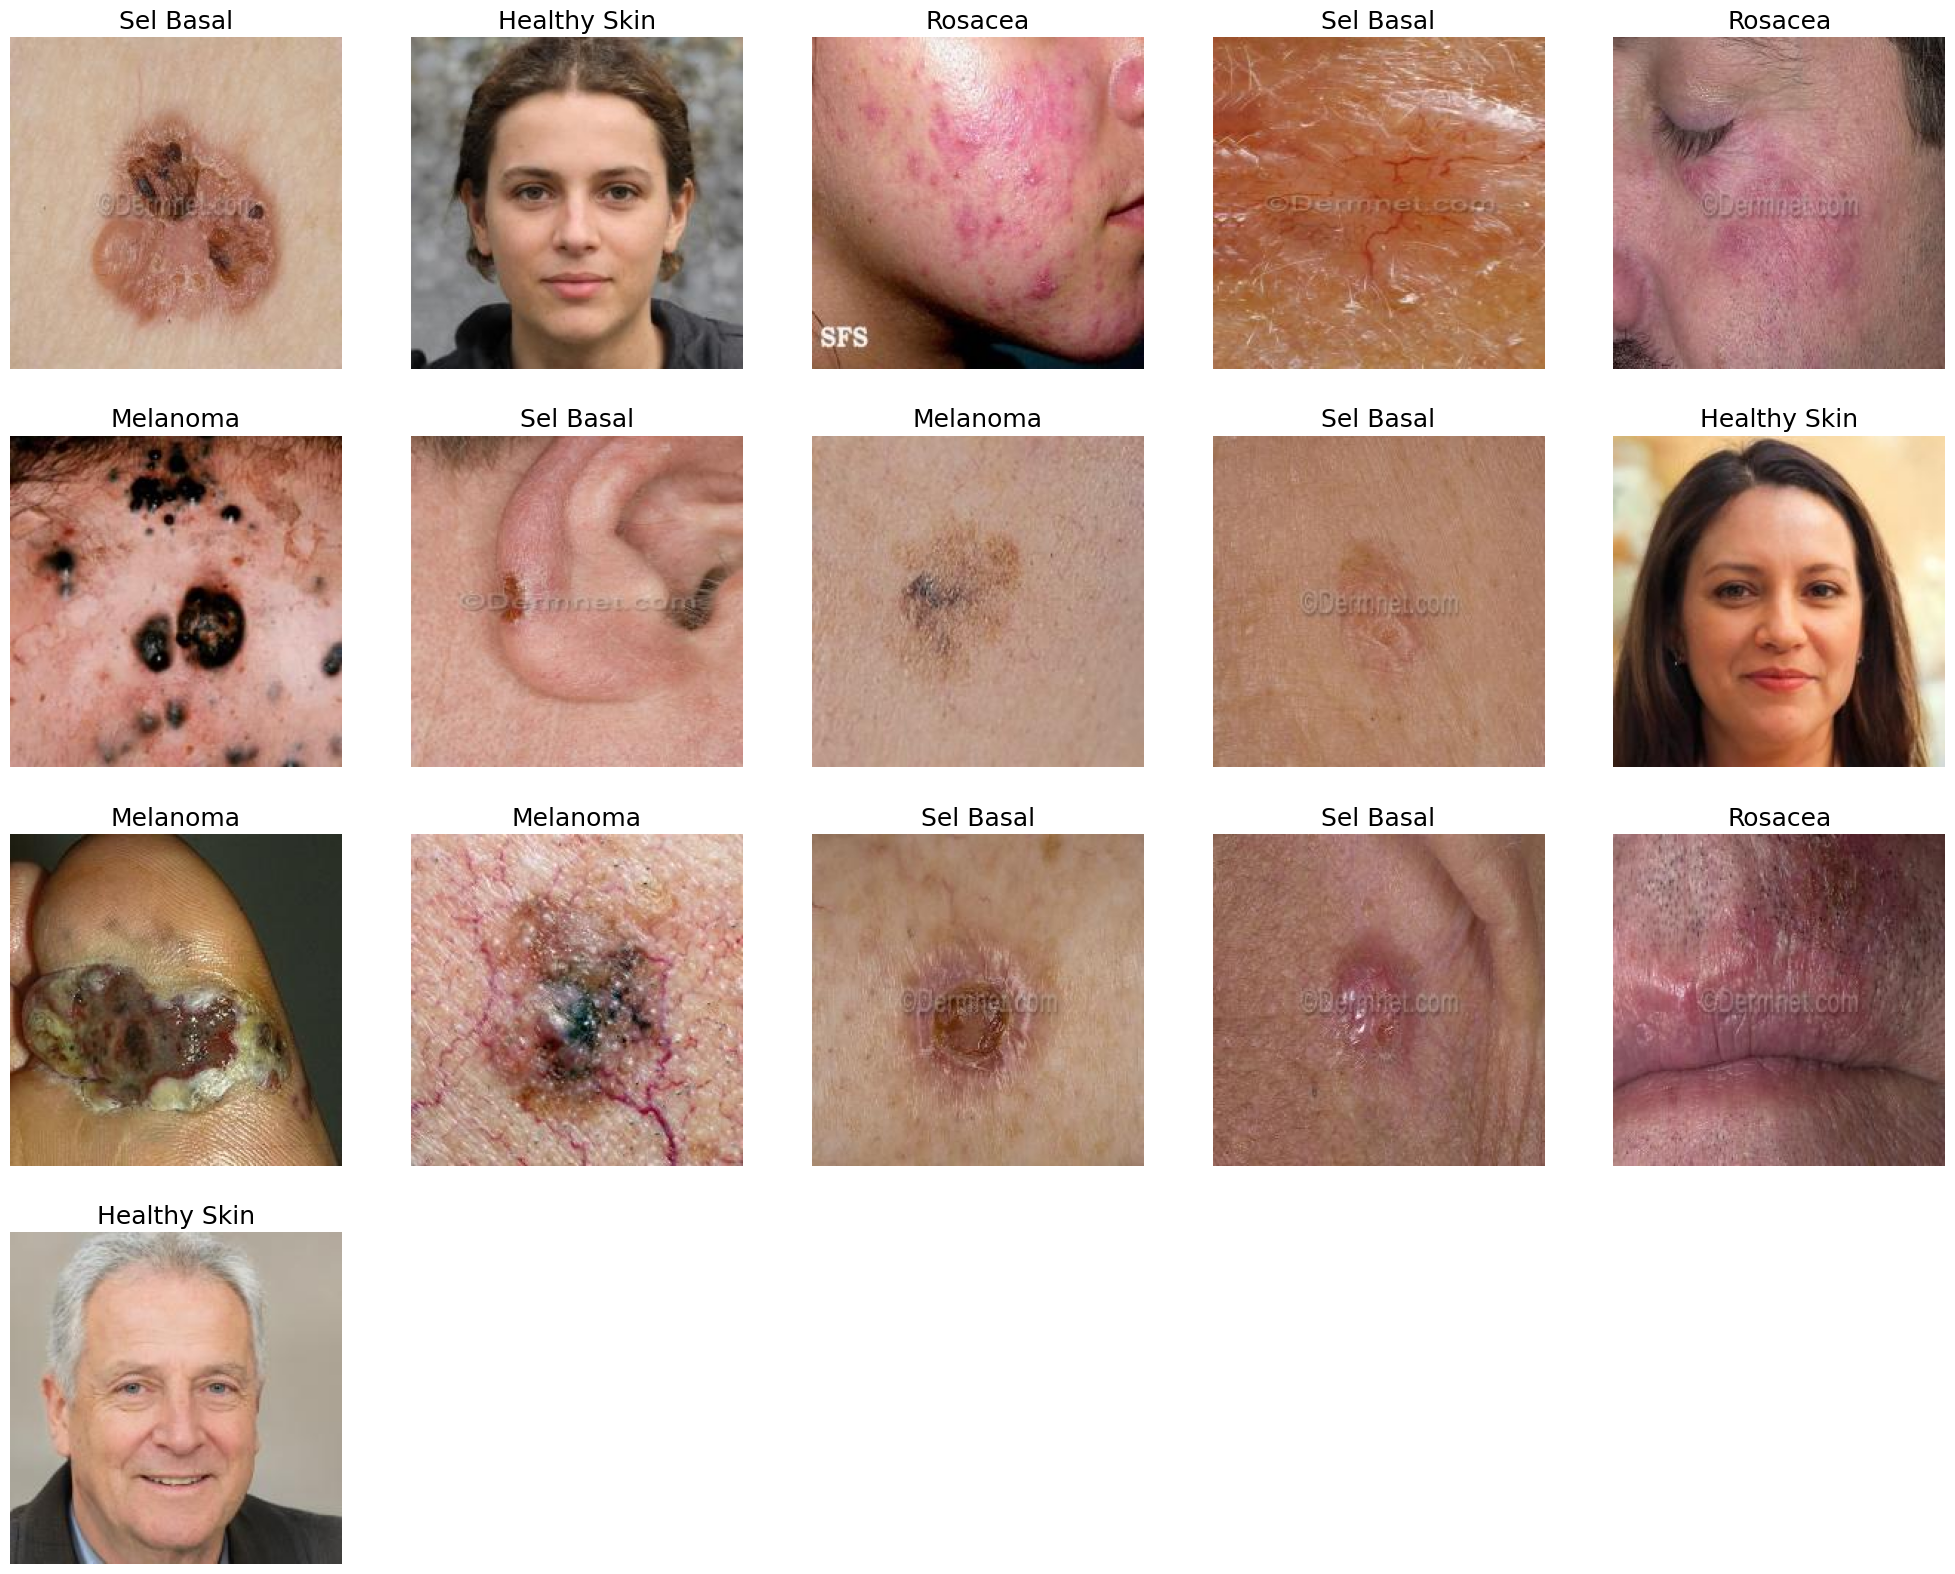

In [6]:
def plot_images_per_batch(gen):
    class_dict=gen.class_indices
    #{'Abyssinian': 0, 'American Bobtail': 1, 'American Shorthair': 2, 'Bengal': 3,
    #Birman': 4, 'Bombay': 5, 'British Shorthair': 6, 'Egyptian Mau': 7, 'Maine Coon': 8, 'Persian': 9,
    #'Ragdoll': 10, 'Russian Blue': 11, 'Siamese': 12, 'Sphynx': 13, 'Tuxedo': 14}

    # Perbedaan antara values() dan keys()
    # t_dict=gen.class_indices.values()
    # dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
    class_dict_keywords=list(class_dict.keys()) #Atau kelas sama saja
    images,labels=next(gen) #next() mengambil gambar dari batch ke batch
    length=len(labels)
    if length<25:
        r=length
    else:
        r=25
    plt.figure(figsize=(25, 25))
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=class_dict_keywords[index]
        plt.title(class_name, fontsize=18)
        plt.axis('off')
    plt.show()
plot_images_per_batch(train_gen)

#Step 5: Membuat callbacks untuk memantau model saat dilatih.
Callbacks yang digunakan akan memantau keakurasian model tiap epoch dan akan memengaruhi perilaku pelatihan model selama proses pelatihan.

In [7]:
#Callbacks untuk Model Training
early_stopping = keras.callbacks.EarlyStopping(monitor = "accuracy",
                               patience = 10,
                               mode = 'max')

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=3, min_lr=1e-6)

#Step 6: Membuat fungsi menampilkan graph plot training model

In [8]:
def plot_training(history):
    sns.set_style('darkgrid')
    plt.figure(figsize=(8,6))
    plt.plot(history.history['accuracy'],c='blue')
    plt.plot(history.history['loss'],c='red')
    plt.plot(history.history['val_accuracy'],c='blue', linestyle='dashed')
    plt.plot(history.history['val_loss'],c='red', linestyle='dashed')
    plt.title("Accuracy and Loss Per Epochs", fontsize=20)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Accuracy and Loss", fontsize=14)
    plt.legend(["Accuracy","Loss","Val_Accuracy","Val_Loss"], fontsize=14,loc=[1.02,0.5])
    plt.show()

#Step 7: Membuat Opsi Data Augmentasi sebagai opsi tambahan untuk model berlayer input.
Data Augmentasi akan berfungsi meninkatkan keakurasian model dan mengurangi terjadinya overfitting

In [9]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  keras.layers.Resizing(224,224),
  keras.layers.RandomCrop(224,224, seed=62),
  keras.layers.RandomFlip("horizontal"),
  keras.layers.RandomRotation(0.3),
  keras.layers.RandomZoom(0.3),
  keras.layers.RandomContrast(0.2),
])

augment_Inception = tf.keras.Sequential([
  keras.layers.Resizing(299,299),
  keras.layers.RandomCrop(299,299, seed=62),
  keras.layers.RandomFlip("horizontal"),
  keras.layers.RandomRotation(0.3),
  keras.layers.RandomZoom(0.3),
  keras.layers.RandomContrast(0.2),
])

In [10]:
#Fungsi Prediksi dengan menggunakan model yang sudah dilatih
def predict_disease(image, model):
    img = keras.preprocessing.image.load_img(image)
    img_arr = keras.utils.img_to_array(img)
    img_arr = img_arr/255.
    img_arr = tf.image.resize(img_arr,[224,224])
    preds_arr = model.predict(tf.expand_dims(img_arr, axis=0))
    pred = np.argmax(preds_arr)
    pred_prob = np.max(preds_arr)
    if pred_prob > 0.8:
        prediction = classes[pred]
    elif pred_prob < 0.8 and pred_prob >= 0.5 :
        prediction = "Kemungkinan "+ str(classes[pred])
    else:
        prediction = "Tidak terdapat penyakit"

    plt.figure(figsize=(2,2), dpi=200)
    plt.imshow(img)
    plt.title(prediction, fontsize=12)
    plt.axis('off')
    plt.figtext(0.5, 0.01, pred_prob, wrap=True, horizontalalignment='center', fontsize=12)

#Fungsi Confussion Matrix
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #fungsi ini akan menampilkan teks yang berwarna cyan, untuk menghighlight teks yang penting seperti metriks akurasi.
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

def CM_report(gen, model):
    y_pred= []
    error_list=[]
    y_true=gen.labels
    classes=list(gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        file=gen.filenames[i]
        pred_index=np.argmax(p)
        true_index=gen.labels[i]  # Ingat labels itu berupa integer
        if pred_index != true_index: # Kondisi dimana misklasifikasi terjadi.
            errors=errors + 1
            file=gen.filenames[i]
            error_class=classes[pred_index]
            t=(file, error_class)
            error_list.append(t)
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # fungsi menghighlight teks
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plotting confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # Membuat laporan klasifikasi tiap kelas
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, f1score

#Melatih model CNN dengan arsitektur ResNet101V2

In [ ]:
# # ResNet101V2

# model_ResNet = keras.applications.ResNet101V2(include_top=False,
#                                             weights='imagenet',
#                                             pooling='max')
# model_ResNet.trainable = False

# i = Input(shape=(RESIZE,RESIZE,3))
# x = model_ResNet(i, training=False)
# x = Flatten()(x)
# x = Dropout(0.25)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.4)(x)
# x = Dense(NUM_CLASSES, activation='softmax')(x)

# model_ResNet = Model(i,x)

# model_ResNet.summary()

#Step 8: Melatih model CNN ResNet101V2

In [ ]:
# model_ResNet.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# history = model_ResNet.fit(train_gen,
#                          epochs=NUM_EPOCHS,
#                          verbose=1,
#                          validation_data=valid_gen,
#                          validation_steps=None,
#                          callbacks=[early_stopping,
#                                     reduce_lr]
# )
# plot_training(history)
# errors, tests, error_list, f1score =CM_report(test_gen, model_ResNet)
# print(f1score)

# Melatih ResNet101v2 dengan Data Augmentation

In [12]:
# ResNet101V2 + Data Augmentation

model_ResNetV2 = keras.applications.ResNet101V2(include_top=False,
                                            weights='imagenet',
                                            pooling='avg')
model_ResNetV2.trainable = False

i = augment(Input(shape=(RESIZE,RESIZE,3)))
x = model_ResNetV2(i, training=False)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

model_ResNetV2 = Model(i,x)

model_ResNetV2.summary()

171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_386CLONE (InputLayer)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101v2 (Functional)             │ (None, 2048)                │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,152,132 (164.61 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 42,626,560 (162.61 MB)

#Step 9: Melatih model CNN ResNet101V2+Augmentation dengan dataset yang sama

In [ ]:
model_ResNetV2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model_ResNetV2.fit(train_gen,
                         epochs=NUM_EPOCHS*3,
                         verbose=1,
                         validation_data=valid_gen,
                         validation_steps=None,
                         callbacks=[early_stopping,
                                    reduce_lr]
)
plot_training(history)
errors, tests, error_list, f1score =CM_report(test_gen, model_ResNetV2)
print(f1score)

#Melatih Model baru dengan InceptionV3

In [16]:
# InceptionV3 + Data Augmentation

model_InceptionV3 = keras.applications.InceptionV3(include_top=False,
                                            weights='imagenet')
model_InceptionV3.trainable = False

i = augment_Inception(Input(shape=(299,299,3)))
x = model_InceptionV3(i, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

model_InceptionV3 = Model(i,x)

model_InceptionV3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               5248

In [13]:
# InceptionV3 + Data Augmentation

model_InceptionV3 = keras.applications.InceptionV3(include_top=False,
                                            weights='imagenet',
                                            pooling='avg')
model_InceptionV3.trainable = False

i = augment_Inception(Input(shape=(299,299,3)))
x = model_InceptionV3(i, training=False)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

model_InceptionV3 = Model(i,x)

model_InceptionV3.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028  

In [ ]:
# model_DenseNet.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# history = model_DenseNet.fit(train_gen,
#                          epochs=NUM_EPOCHS,
#                          verbose=1,
#                          validation_data=valid_gen,
#                          validation_steps=None,
#                          callbacks=[early_stopping,
#                                     reduce_lr]
# )
# plot_training(history)
# errors, tests, error_list, f1score =CM_report(test_gen, model_DenseNet)
# print(f1score)

#Selesai

In [ ]:
image_url="https://www.westervilledermatology.com/wp-content/uploads/2021/09/iStock-1303191775-scaled.jpg"
image = keras.utils.get_file(origin=image_url)

# print("Model Resnet101V2")
# predict_disease(image, model_ResNet)

print("Model Resnet101V2 + Data Augmentation")
predict_disease(image, model_ResNetV2)

# print("Model DenseNet169")
# predict_disease(image, model_DenseNet)

# print("Model gabungan")
# predict_disease(image, model_mixed)

Model Resnet101V2 + Data Augmentation
1/1 [==============================] - 0s 29ms/step
Model DenseNet169
1/1 [==============================] - 0s 36ms/step


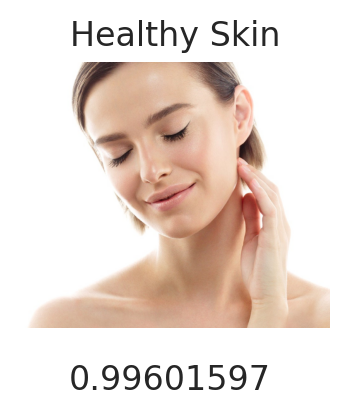

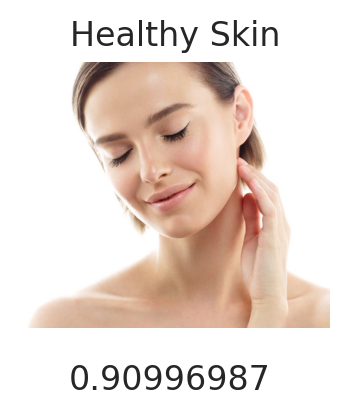

In [ ]:
image_url="https://drrashmishetty.com/wp-content/uploads/2019/01/healthy-skin.png"
image = keras.utils.get_file(origin=image_url)

# print("Model Resnet101V2")
# predict_disease(image, model_ResNet)

print("Model Resnet101V2 + Data Augmentation")
predict_disease(image, model_ResNetV2)

# print("Model DenseNet169")
# predict_disease(image, model_DenseNet)

In [ ]:
model_path = '/content/drive/MyDrive/dermafie/model'
tf.saved_model.save(model_ResNetV2, model_path)


NameError: name 'tf' is not defined

In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    --signature_name=serving_default \
    --saved_model_tags=serve \
    /content/drive/MyDrive/dermafie/model/saved_model.pb \
    /content/drive/MyDrive/dermafie/web_model


2024-06-15 11:37:28.163609: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 11:37:30.219919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 963, in main
    convert(argv[0].split(' '))
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 949, in convert
    _dispatch_converter(input_format, output_fo